In [2]:
import itertools
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import Normalizer

In [3]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
train_samples = 10000
test_size = 2000
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=test_size
)
norm_x = Normalizer().fit_transform(X_train, y_train)

In [30]:
indices = np.int32(np.floor(np.linspace(0, y_train.size, 6)))
folds = np.empty((5, 2), dtype=int)
folds[:, 0] = indices[:-1]
folds[:, 1] = indices[1:]

In [4]:
def accuracy(y, gt):
    return np.sum(y == gt) / y.size

def cross_validation_inter(model_provider, init_args, norm):
    train_x = norm_x if norm else X_train
    train_y = y_train
    sum_acc = 0
    for begin, end in folds:
        model = model_provider(*init_args)
        ar = np.arange(begin, end)
        model = model.fit(np.delete(train_x, ar, 0), np.delete(train_y, ar, 0))
        a= model.predict(train_x[begin:end])
        sum_acc += accuracy(a, train_y[begin:end])
    return sum_acc / folds.shape[0]

def cross_validation(model_provider, hyper_params, norm=False):
    best_param = []
    best_accuracy = 0
    for args in tqdm(hyper_params):
        acc = cross_validation_inter(model_provider, args, norm)
        if acc > best_accuracy:
            best_accuracy = acc
            best_param = [args]
        elif np.abs(acc - best_accuracy) < 1e-8:
            best_param += [args]
    return best_param, best_accuracy

In [5]:
def show(images, gt, preds, n_max):
    size = min(n_max, gt.size)
    n = 8
    m = (size + n - 1) // n
    fig = plt.figure()
    fig.set_size_inches(3 * n, 3 * m)
    for i in range(size):
        axs = plt.subplot(m, n, i+1)
        axs.imshow(images[i].reshape(28, 28), cmap='gray')
        axs.axis('off')
        axs.set_title(("gt=%s, y=%s" % (gt[i], preds[i])))
    plt.show()

# Best features

In [156]:
Tree_provider = lambda c, s, d, l, f: DecisionTreeClassifier(criterion=c, splitter=s, max_depth=d, min_samples_leaf=l, max_features=f)
tree = Tree_provider("entropy", "best", None, 1, None)

In [157]:
tree.fit(norm_x, y_train)

DecisionTreeClassifier(criterion='entropy')

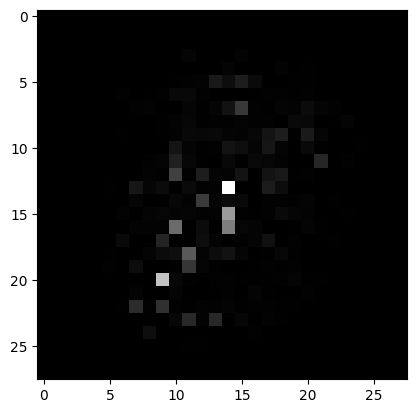

In [158]:
plt.imshow(tree.feature_importances_.reshape(28,28), cmap='gray')

sorted_ind = np.flip(np.argsort(tree.feature_importances_))

In [164]:
LogRegr_provider = lambda c, p, s: LogisticRegression(penalty=p, C=c, solver=s)
classifier = LogRegr_provider(None, 'none', 'saga')

In [166]:
for i in [100, 200, 300]:
    cl = clone(classifier)
    cl.fit(norm_x[:, sorted_ind[:i]], y_train)
    print("%d features: %f" % (i, accuracy(cl.predict(Normalizer().fit_transform(X_test)[:,sorted_ind[:i]]), y_test)))

C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


100 features: 0.880500


C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


200 features: 0.892000
300 features: 0.901000


C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# SV

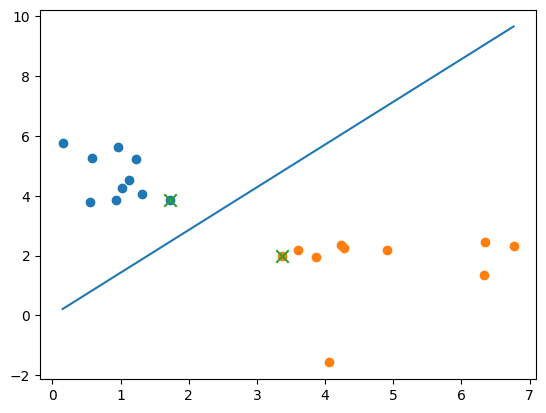

In [28]:
x1 = np.random.randn(10, 2)*np.array([0.5, 1]) + np.array([[1, 5]])
x2 = np.random.randn(10, 2)*np.array([1, 1]) + np.array([[5, 2]])

w = np.array([-1., 0.7])
w /= np.linalg.norm(w)
b = 0

sv = np.empty((2,2))
sv[0] = x1[np.argmin(x1 @ w + b)]
sv[1] = x2[np.argmin(-(x2 @ w + b))]

plt.scatter(x1[:, 0], x1[:, 1])
plt.scatter(x2[:, 0], x2[:, 1])
plt.scatter(sv[:, 0], sv[:, 1], s=80, marker='x')
x = np.concatenate((x1, x2), axis=0)
line = np.array([[np.min(x[:, 0]), 0], [np.max(x[:, 0]), 0]])
line[:, 1] = (-w[0]* line[:, 0] - b) / w[1]
plt.plot(line[:, 0], line[:, 1])

In [6]:
mask = np.logical_or(y == '1', y == '3')
X_train, X_test, y_train, y_test = train_test_split(
    X[mask], y[mask], train_size=2000, test_size=10
)
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [7]:
x1 = X_train[y_train == '1']
x2 = X_train[y_train == '3']
x1_ind = np.where(np.abs(x1 @ model.coef_.flatten() + model.intercept_ + 1) < 1e-3)[0]
x2_ind = np.where(np.abs(x2 @ model.coef_.flatten() + model.intercept_ - 1) < 1e-3)[0]

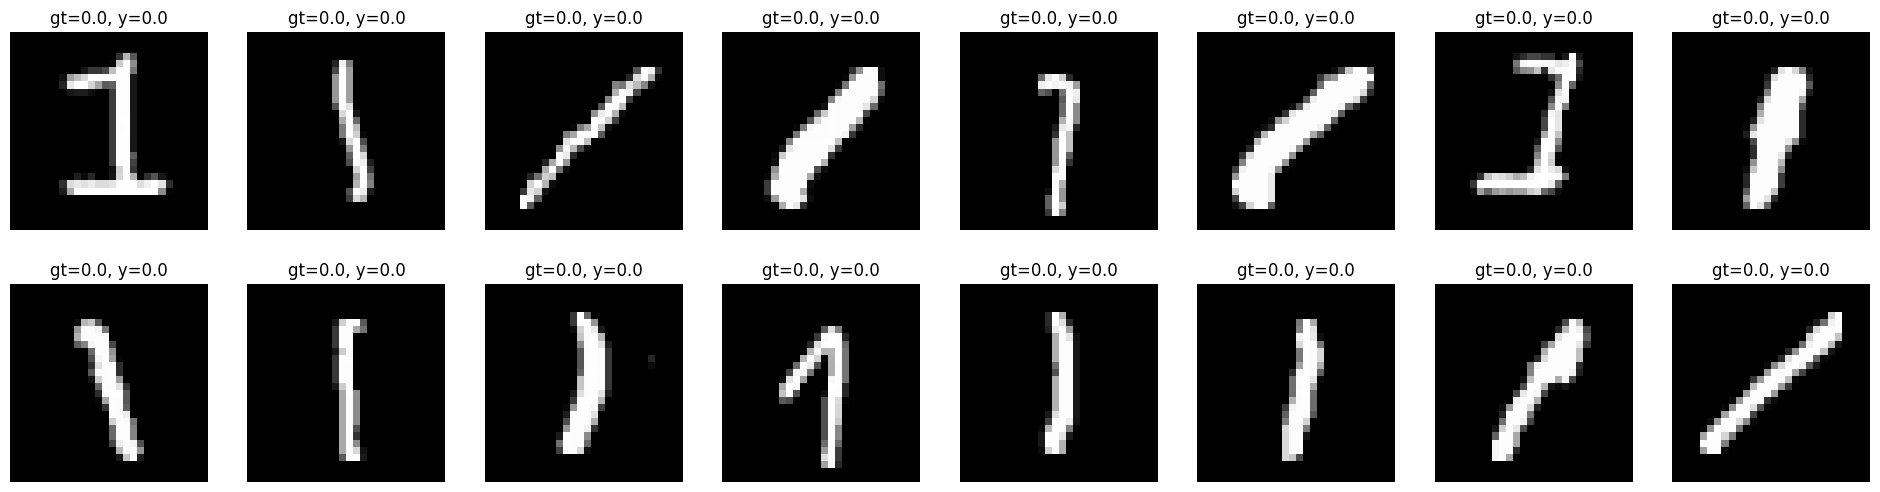

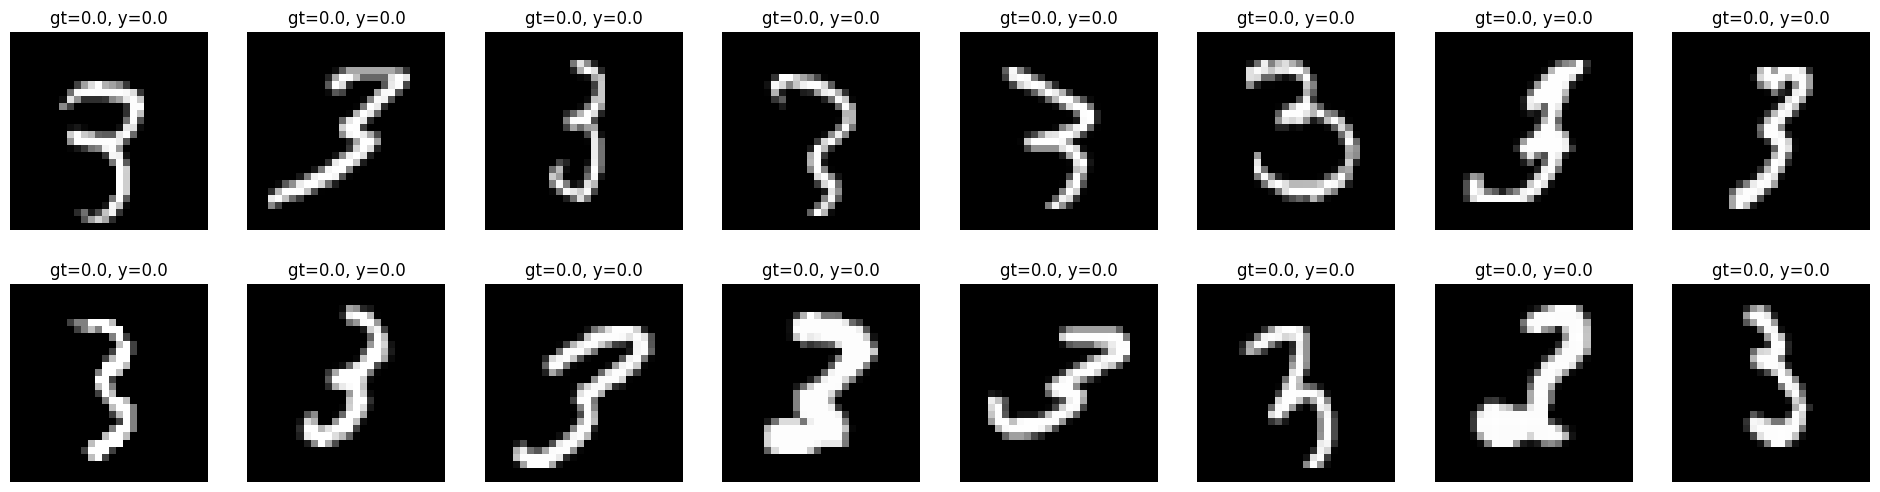

In [8]:
n = 16
show(x1[x1_ind[:n]], np.zeros(n), np.zeros(n), n)
show(x2[x2_ind[:n]], np.zeros(n), np.zeros(n), n)

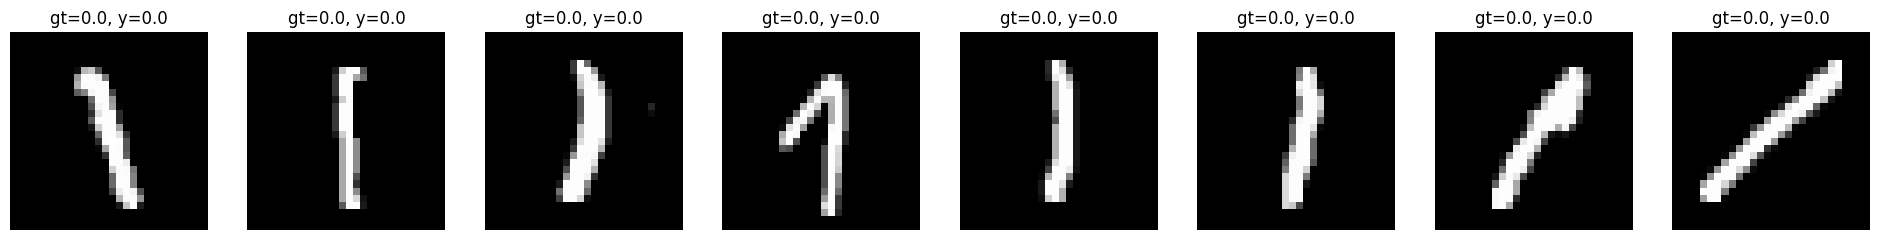

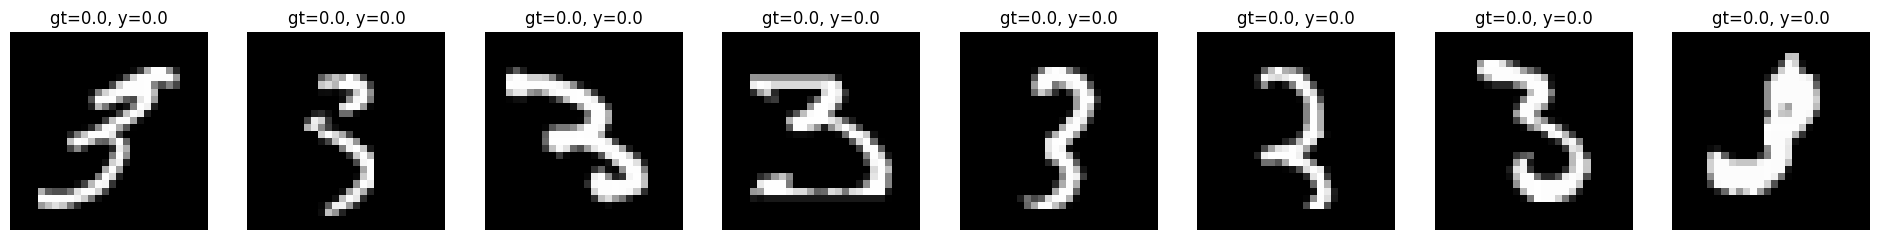

In [9]:
show(model.support_vectors_[8:], np.zeros(8), np.zeros(8), 8)
show(model.support_vectors_[-8:], np.zeros(8), np.zeros(8), 8)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=1000, test_size=10
)

In [ ]:
coeff = np.empty(10, dtype=object)
for i in range(coeff.size):
    logreg = LogisticRegression(solver='saga', max_iter=0)
    logreg.fit(X_train, y_train)
    logreg.coef_ = np.random.randn(*logreg.coef_.shape)
    logreg.max_iter = 400
    logreg.fit(X_train, y_train)
    coeff[i] = logreg.coef_

In [113]:
for c in coeff:
    print("max|c|: %.4f, mean|c|: %.4f, max|c - c0|: %.4f, mean|c - c0|: %.5f" 
        % (np.max(np.abs(c)), np.mean(np.abs(c)), np.max(np.abs(c - coeff[0])), np.mean(np.abs(c - coeff[0]))))

max|c|: 0.0060, mean|c|: 0.0006, max|c - c0|: 0.0000, mean|c - c0|: 0.00000
max|c|: 0.0060, mean|c|: 0.0006, max|c - c0|: 0.0002, mean|c - c0|: 0.00003
max|c|: 0.0060, mean|c|: 0.0006, max|c - c0|: 0.0003, mean|c - c0|: 0.00002
max|c|: 0.0059, mean|c|: 0.0006, max|c - c0|: 0.0002, mean|c - c0|: 0.00002
max|c|: 0.0059, mean|c|: 0.0006, max|c - c0|: 0.0003, mean|c - c0|: 0.00002
max|c|: 0.0059, mean|c|: 0.0006, max|c - c0|: 0.0002, mean|c - c0|: 0.00002
max|c|: 0.0060, mean|c|: 0.0006, max|c - c0|: 0.0002, mean|c - c0|: 0.00003
max|c|: 0.0059, mean|c|: 0.0006, max|c - c0|: 0.0003, mean|c - c0|: 0.00003
max|c|: 0.0060, mean|c|: 0.0006, max|c - c0|: 0.0003, mean|c - c0|: 0.00002
max|c|: 0.0059, mean|c|: 0.0006, max|c - c0|: 0.0002, mean|c - c0|: 0.00003


# RF

In [151]:
from collections import Counter

class RandomForest:
    class RandomTree:
        def __init__(self, tree=None, ind=None):
            self.tree = tree
            self.feature_ind = ind

        def fit(self, x, y):
            n, m = x.shape
            ind_x = np.random.choice(np.arange(n), n, True)
            self.feature_ind = np.random.choice(np.arange(m), int(np.sqrt(m)), False)
            self.tree.fit(x[ind_x][:, self.feature_ind], y[ind_x])
        
        def predict(self, x):
            return self.tree.predict(x[:, self.feature_ind])
    
    def __init__(self, n_trees):
        self.trees = np.empty(n_trees, dtype=object)
        for i in range(n_trees):
            self.trees[i] = RandomForest.RandomTree(
                    DecisionTreeClassifier(
                        criterion='entropy', 
                        splitter='best', 
                        max_depth=20, 
                        min_samples_leaf=1, 
                        max_features=None
                    )
                )
    
    def fit(self, x, y, boosting=False):
        np.vectorize(RandomForest.RandomTree.fit, excluded=['x', 'y'])(self.trees, x=x, y=y)

    def predict(self, x):
        y = np.vectorize(RandomForest.RandomTree.predict, excluded=['x'])(self.trees, x=x)
        y = np.vstack(y)
        p = np.empty(x.shape[0], dtype=object)
        for i in range(p.size):
            v, c = np.unique(y[:, i], return_counts=True)
            p[i] = v[np.argmax(c)]
        return p

In [154]:
rf = RandomForest(100)
rf.fit(X_train, y_train)

In [155]:
p = rf.predict(X_test)
accuracy(p, y_test)

0.922

# 

In [ ]:
from collections import Counter

class RandomForest:
    class RandomTree:
        def __init__(self, tree=None, ind=None):
            self.tree = tree
            self.feature_ind = ind

        def fit(self, x, y, waights=None):
            n, m = x.shape
            ind_x = np.random.choice(np.arange(n), n, True)
            self.feature_ind = np.random.choice(np.arange(m), int(np.sqrt(m)), False)
            self.tree.fit(x[ind_x][:, self.feature_ind], y[ind_x], waights)
        
        def predict(self, x):
            return self.tree.predict(x[:, self.feature_ind])
    
    def __init__(self, n_trees):
        self.n_real = 0
        self.trees = np.empty(n_trees, dtype=object)
        for i in range(n_trees):
            self.trees[i] = RandomForest.RandomTree(
                    DecisionTreeClassifier(
                        criterion='entropy', 
                        splitter='best', 
                        max_depth=20, 
                        min_samples_leaf=1, 
                        max_features=None
                    )
                )
    
    def fit(self, x, y, boosting=False):
        if boosting:
            waights = np.ones(y.size) * 30
            for tree in self.trees:
                tree.fit(x, y, waights / np.linalg.norm(waights))
                self.n_real += 1
                p = self.predict(x) == y
                waights[1 - p] += 1
                waights[p * (waights > 0)] -= 1
        else:
            np.vectorize(RandomForest.RandomTree.fit, excluded=['x', 'y', 'waights'])(self.trees, x=x, y=y, waights=None)
            self.n_real = self.trees.size

    def predict(self, x):
        y = np.vectorize(RandomForest.RandomTree.predict, excluded=['x'])(self.trees[:self.n_real], x=x)
        y = np.vstack(y)
        p = np.empty(x.shape[0], dtype=object)
        for i in range(p.size):
            v, c = np.unique(y[:, i], return_counts=True)
            p[i] = v[np.argmax(c)]
        return p

In [ ]:
rf = RandomForest(50)
rf.fit(X_train, y_train, True)

In [ ]:
p = rf.predict(X_test)
accuracy(p, y_test)

0.8865

In [ ]:
rf = RandomForest(50)
rf.fit(X_train, y_train)

In [ ]:
p = rf.predict(X_test)
accuracy(p, y_test)

0.916

# ovr

In [12]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
train_samples = 10000
test_size = 2000

In [14]:
SVC_provider = lambda c, k: SVC(C=c, kernel=k)

In [15]:
LogRegr_provider = lambda c, p, s: LogisticRegression(penalty=p, C=c, solver=s)

In [17]:
import time
n_classes = ['3', '5', '7']
time_svc = []
time_logreg = []
for i in n_classes:
    mask = y < i
    X_train, X_test, y_train, y_test = train_test_split(
        X[mask], y[mask], train_size=train_samples, test_size=test_size
    )
    norm_x = Normalizer().fit_transform(X_train, y_train)
    indices = np.int32(np.floor(np.linspace(0, y_train.size, 6)))
    folds = np.empty((5, 2), dtype=int)
    folds[:, 0] = indices[:-1]
    folds[:, 1] = indices[1:]
    
    t0 = time.time()
    model = SVC_provider(10, 'rbf')
    model = model.fit(X_train, y_train)
    t1 = time.time()
    model = LogRegr_provider(10, 'l2', 'sag')
    model = model.fit(X_train, y_train)
    t2 = time.time()
    time_svc.append(t1-t0)
    time_logreg.append(t2-t1)
for i in range(len(n_classes)):
    print("%s classes: svc - %ds, logreg - %ds" % (n_classes[i], time_svc[i], time_logreg[i]))

C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


3 classes: svc - 3s, logreg - 13s
5 classes: svc - 7s, logreg - 21s
7 classes: svc - 11s, logreg - 29s


C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# nothing

In [9]:
model = LogisticRegression("l1", C=10, max_iter=0, solver='saga')
model = model.fit(norm_x, y_train)

In [10]:
np.min(model.coef_[0]), np.max(model.coef_[0]), model.coef_[0, 0]

(0.0, 0.0, 0.0)

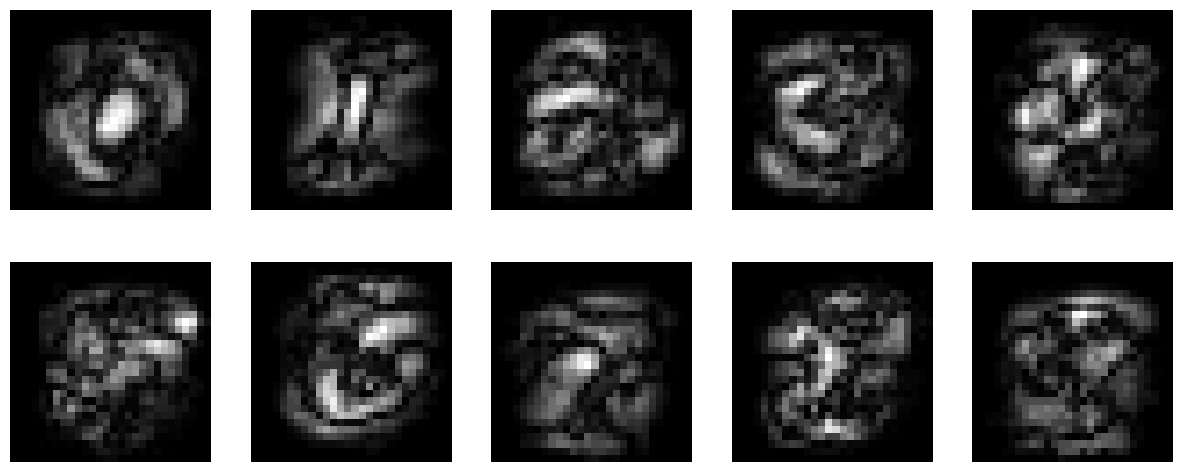

In [8]:
plt.figure().set_size_inches(15, 6)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.abs(model.coef_[i]).reshape(28, 28), cmap='gray')
    plt.axis('off')

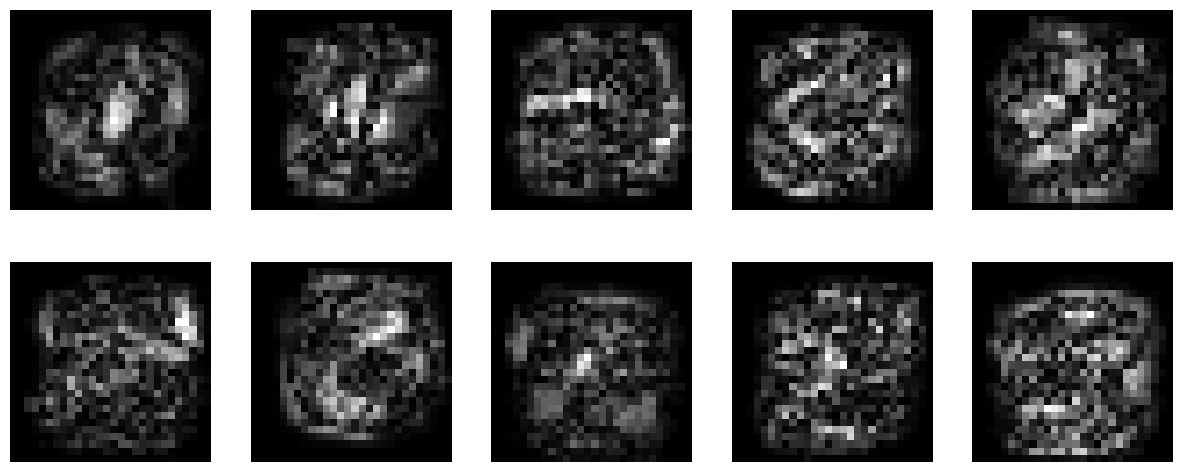

In [26]:
plt.figure().set_size_inches(15, 6)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.abs(model.coef_[i]).reshape(28, 28), cmap='gray')
    plt.axis('off')

# frame

In [20]:
model1 = LogRegr_provider(10, 'l2', 'sag')
model1 = model1.fit(norm_x, y_train)

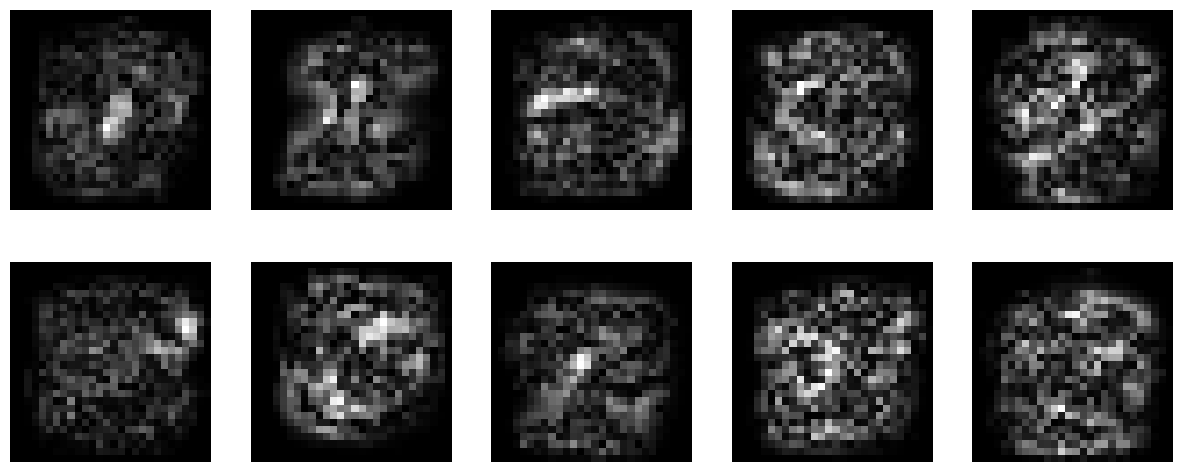

In [21]:
plt.figure().set_size_inches(15, 6)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.abs(model1.coef_[i].reshape(28, 28)), cmap='gray')
    plt.axis('off')

sum([yi==ci]*log(f(xi))) = yi*f(xi) + (1-yi)*f(xi)

In [ ]:
log(1+exp(-M)) 
M=y_i*W*X_i
sum([yi=Ci])

In [22]:
model2 = LogRegr_provider(10, 'l1', 'saga')
model2 = model2.fit(norm_x, y_train)

C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


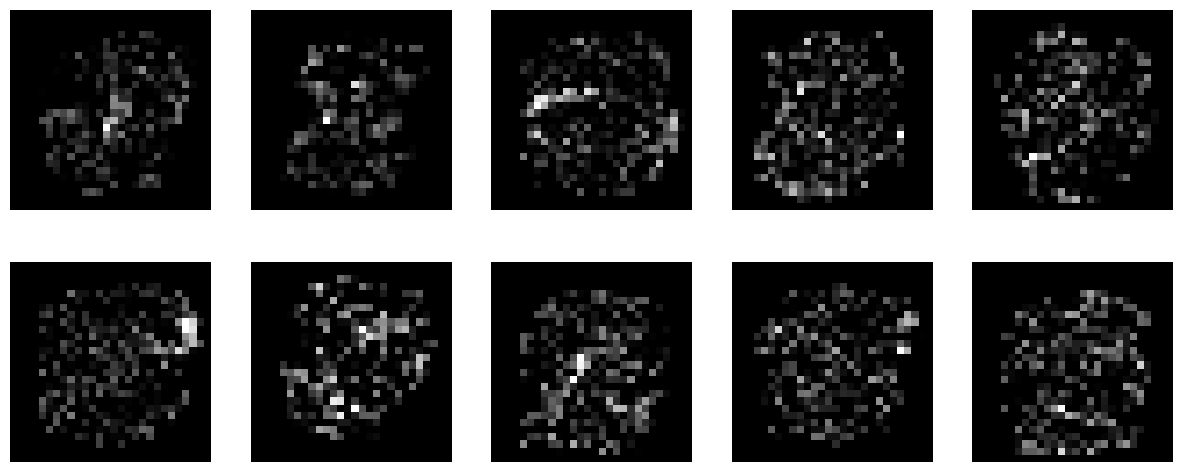

In [23]:
plt.figure().set_size_inches(15, 6)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.abs(model2.coef_[i]).reshape(28, 28), cmap='gray')
    plt.axis('off')

# KNN

In [6]:
K = ['uniform', 'distance']
p = [1, 2]
N = [5, 17, 23, 41, 53]
hp_KNN = list(itertools.product(K, p, N))

In [7]:
KNN_provider = lambda k, p, n: KNeighborsClassifier(n, weights=k, p=p)

In [8]:
res_KNN, acc_KNN = cross_validation(KNN_provider, hp_KNN)

100%|██████████| 20/20 [05:23<00:00, 16.16s/it]


In [31]:
print('validation accuracy:', acc_KNN)

validation accuracy: 0.9464


In [9]:
models_KNN = []
for (i, arg) in enumerate(res_KNN):
    model = KNN_provider(*arg)
    model = model.fit(X_train, y_train)
    print("test accuracy with args", arg, ":", accuracy(model.predict(X_test), y_test))
    models_KNN += [model]

test accuracy with args ('distance', 2, 5) : 0.96


## pic

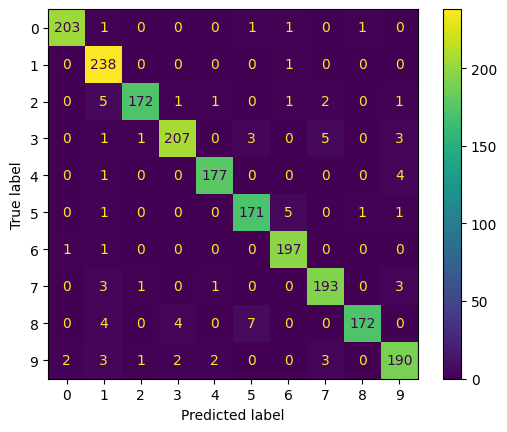

In [10]:
preds = models_KNN[0].predict(X_test)
matr = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(matr).plot()
plt.show()

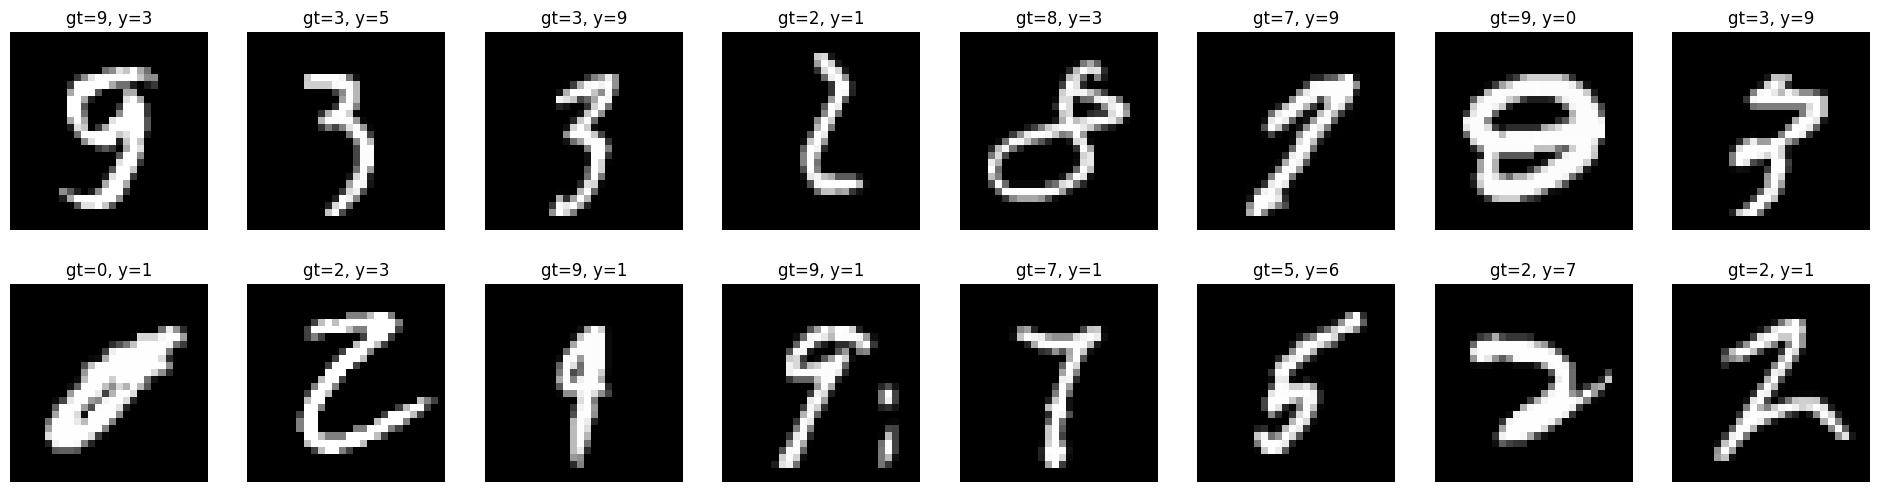

In [11]:
mask = np.logical_not(preds == y_test)
show(X_test[mask], y_test[mask], preds[mask], 16)

# Tree

In [12]:
criterion = ["gini", "entropy"]
splitter = ["best", "random"]
max_depth = [10, 20, 30, 40]
min_samples_leaf = [1, 5, 10, 20]
max_features = [None, "sqrt", "log2"]
hp_tree = list(itertools.product(criterion, splitter, max_depth, min_samples_leaf, max_features))

In [13]:
Tree_provider = lambda c, s, d, l, f: DecisionTreeClassifier(criterion=c, splitter=s, max_depth=d, min_samples_leaf=l, max_features=f)

In [14]:
res_tree, acc_tree = cross_validation(Tree_provider, hp_tree)

100%|██████████| 192/192 [08:54<00:00,  2.78s/it]


In [30]:
print('validation accuracy:', acc_tree)

validation accuracy: 0.8101


In [15]:
models_tree = []
for (i, arg) in enumerate(res_tree):
    model = Tree_provider(*arg)
    model = model.fit(X_train, y_train)
    print("test accuracy with args", arg, ":", accuracy(model.predict(X_test), y_test))
    models_tree += [model]

test accuracy with args ('entropy', 'random', 20, 1, None) : 0.819


## pic

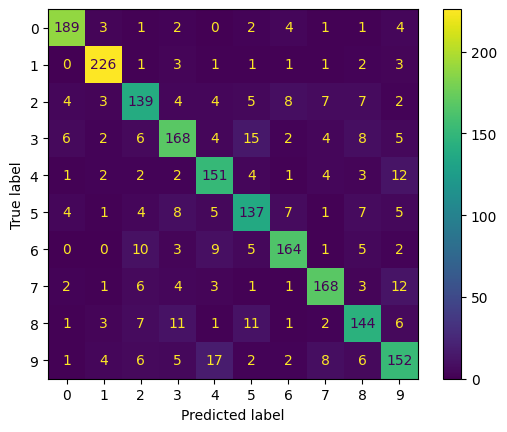

In [16]:
preds = models_tree[0].predict(X_test)
matr = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(matr).plot()
plt.show()

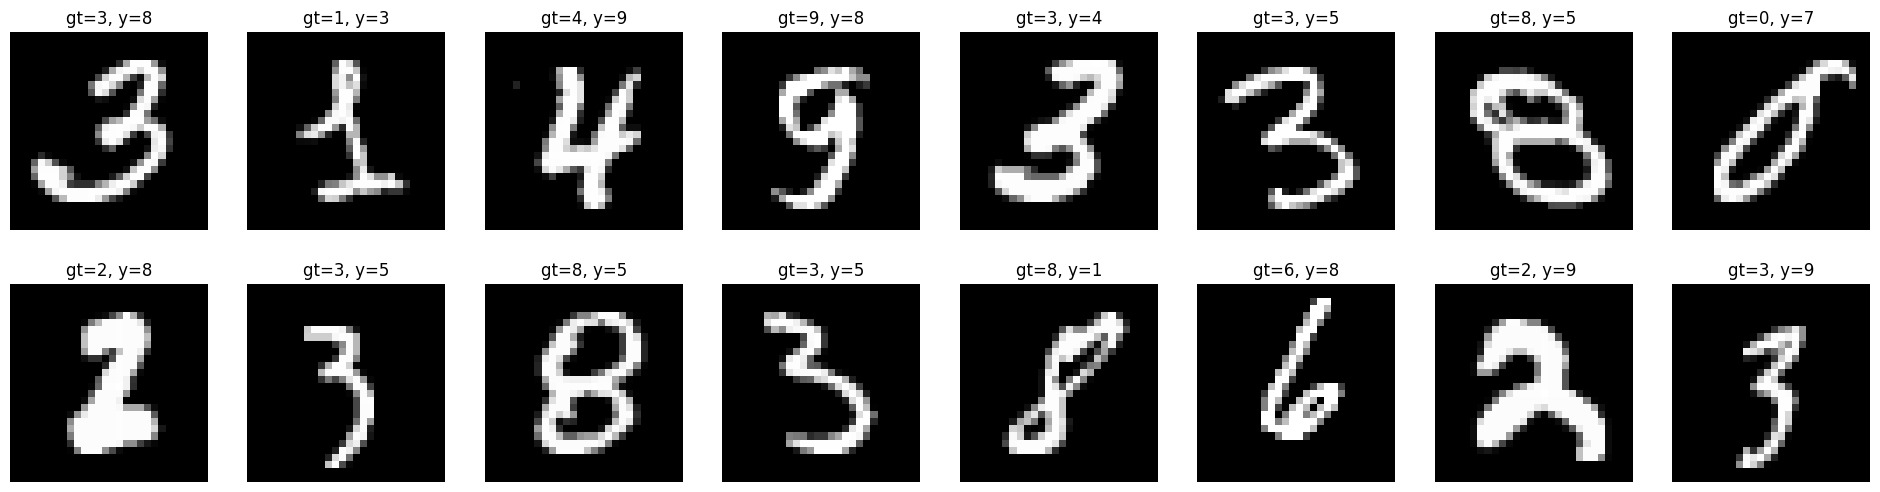

In [17]:
mask = np.logical_not(preds == y_test)
show(X_test[mask], y_test[mask], preds[mask], 16)

# SVC

In [18]:
C = [1, 2, 5, 10, 100]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
hp_svc = list(itertools.product(C, kernel))

In [12]:
SVC_provider = lambda c, k: SVC(C=c, kernel=k)

In [20]:
res_svc, acc_svc = cross_validation(SVC_provider, hp_svc)

100%|██████████| 20/20 [22:33<00:00, 67.66s/it]


In [29]:
print('validation accuracy:', acc_svc)

validation accuracy: 0.9646000000000001


In [21]:
models_svc = []
for (i, arg) in enumerate(res_svc):
    model = SVC_provider(*arg)
    model = model.fit(X_train, y_train)
    print("test accuracy with args", arg, ":", accuracy(model.predict(X_test), y_test))
    models_svc += [model]

test accuracy with args (10, 'rbf') : 0.971
test accuracy with args (100, 'rbf') : 0.9705


## pic

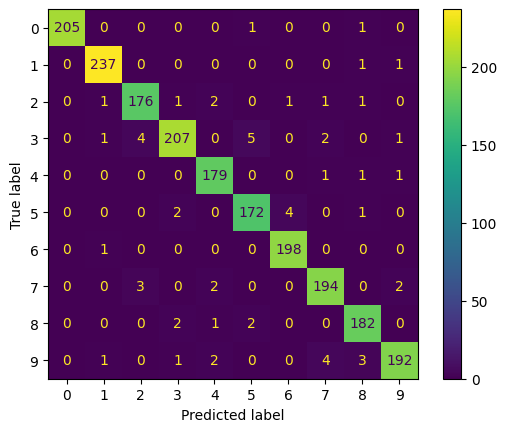

In [22]:
preds = models_svc[0].predict(X_test)
matr = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(matr).plot()
plt.show()

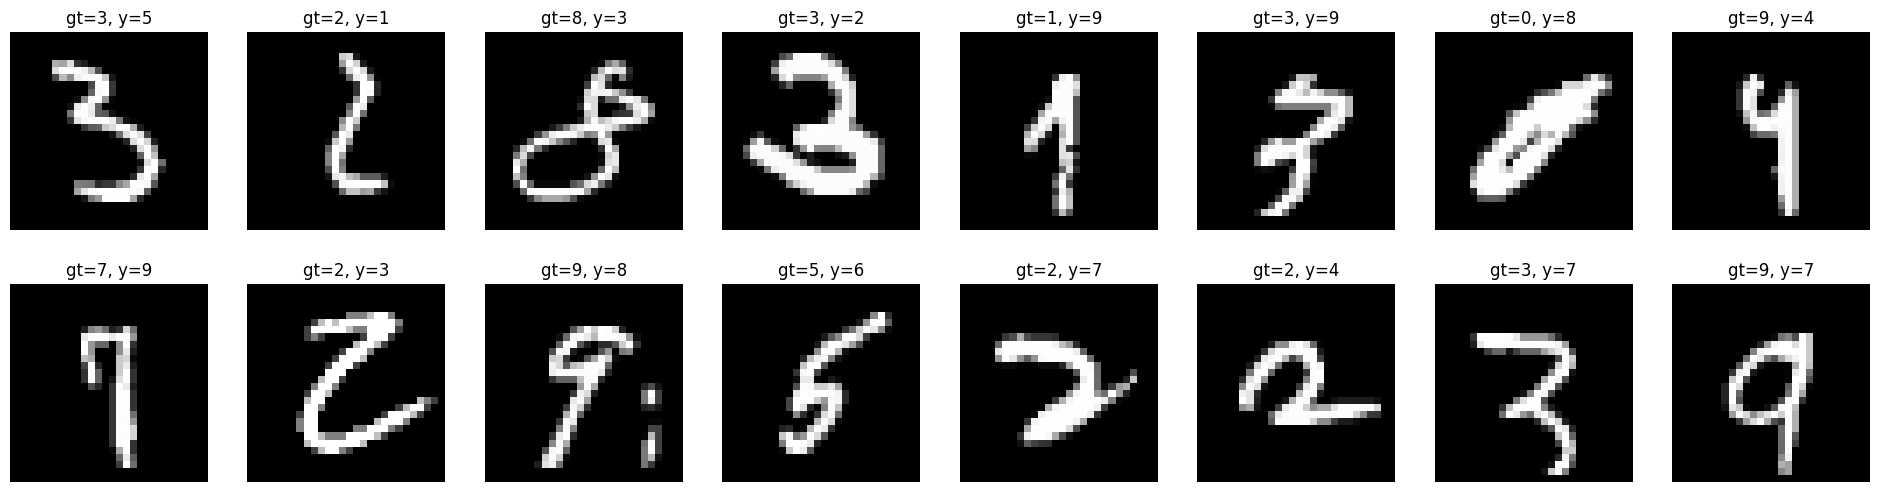

In [23]:
mask = np.logical_not(preds == y_test)
show(X_test[mask], y_test[mask], preds[mask], 16)

# Log Regression

In [24]:
C = [1, 2, 5, 10, 100]
penalty = ['l2']
sover = ['sag']
hp_logR = list(itertools.product(C, penalty, sover)) + [(1.0, 'none', 'sag')]

In [13]:
LogRegr_provider = lambda c, p, s: LogisticRegression(penalty=p, C=c, solver=s)

In [28]:
res_logR, acc_logR = cross_validation(LogRegr_provider, hp_logR, True)

 67%|██████▋   | 4/6 [04:49<02:44, 82.18s/it]C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-package

In [32]:
print('validation accuracy:', acc_logR)

validation accuracy: 0.9152000000000001


In [42]:
models_logR = []
for (i, arg) in enumerate(res_logR):
    model = LogRegr_provider(*arg)
    model = model.fit(norm_x, y_train)
    print("test accuracy with args", arg, ":", accuracy(model.predict(Normalizer().fit_transform(X_test)), y_test))
    models_logR = [model]

test accuracy with args (10, 'l2', 'sag') : 0.9135


C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## pic

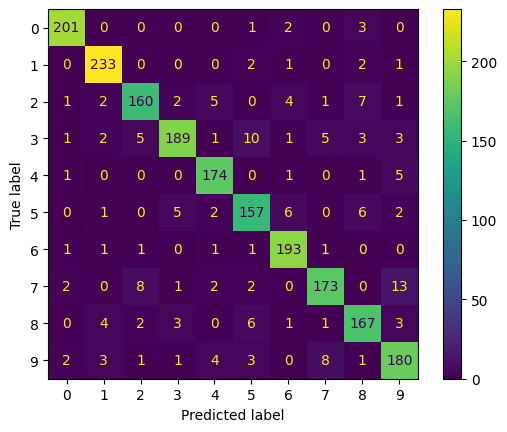

In [43]:
preds = models_logR[0].predict(Normalizer().fit_transform(X_test))
matr = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(matr).plot()
plt.show()

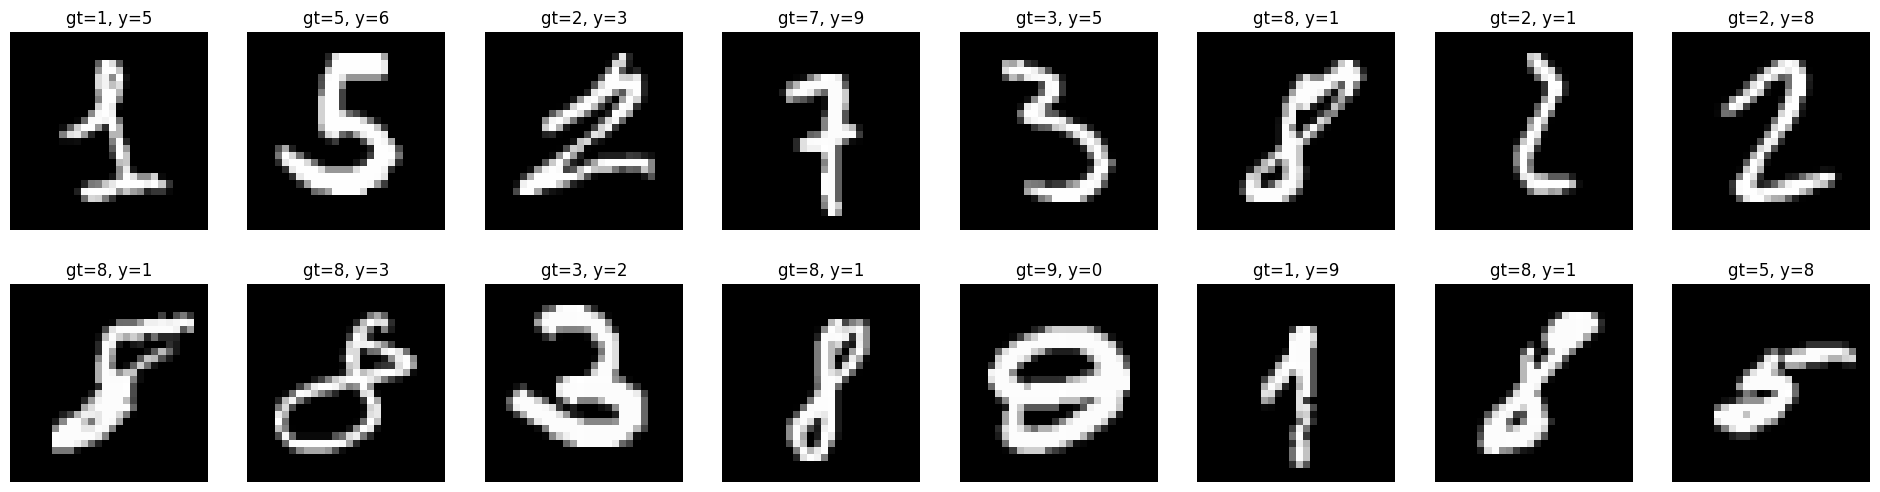

In [44]:
mask = np.logical_not(preds == y_test)
show(X_test[mask], y_test[mask], preds[mask], 16)

In [ ]:
H(i) - w1*H1 - w2*H2